In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 800
signal_to_noise = 4


nsamples = 20
L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=800.0
level=1, num_groups=3, mean_size=266.7
level=2, num_groups=7, mean_size=114.3
level=3, num_groups=16, mean_size=50.0
level=4, num_groups=800, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([  0, 800]),
 array([  0, 200, 400, 800]),
 array([  0, 100, 200, 300, 400, 600, 700, 800]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=26.023609588390677, noise_var=6.601792435170816
SNR=3.941900604107275, signal_to_noise=4


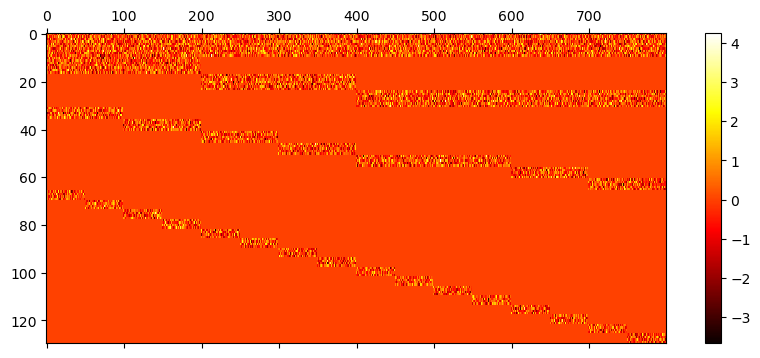

(800, 130)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [9]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [10]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

In [11]:
for _ in range(20):
    true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
    true_mfm.inv_coefficients(printing=True, refine=False)#eps=1e-16) 

    inv_A = np.linalg.inv(true_mfm.matrix())
    print(mf.rel_diff(true_mfm.inv(), inv_A))
    assert np.allclose(true_mfm.inv(), inv_A)

    assert np.allclose(np.diag(inv_A), true_mfm.diag_inv())

    F_Lm1 = np.random.randn(F_Lm1.shape[0], F_Lm1.shape[1])
    D = np.random.rand(D.size) + 1e-4
print("PASSED")

1.0731448505346344e-14
1.3326831547770574e-13
1.36614571964867e-13
1.3876380151747341e-13
1.1006201337327376e-13
1.4756902620242904e-13
1.2396825668171167e-13
1.2337997310383797e-13
1.2954722830128972e-13
1.2344362566268577e-13
1.3506999892975352e-13
1.1004978407990239e-13
1.4106320689637825e-13
1.424410322966408e-13
1.760414782740904e-13
1.1948784038713294e-13
1.4532765555931886e-13
1.5620569529742403e-13
1.0716292898907937e-13
1.438879307476718e-13
PASSED


In [12]:
for _ in range(20):
    v = np.random.randn(n, 1)


    hat_x = true_mfm.solve(v, eps=1e-12, max_iter=20, printing=False)
    reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
    print(f"solve {reldiff=}")
    assert reldiff < 1e-9

solve reldiff=1.860342469436696e-12
solve reldiff=2.4351256668194716e-12
solve reldiff=2.954981256293662e-12
solve reldiff=3.6319242951166445e-12
solve reldiff=1.6710592854393109e-12
solve reldiff=2.8758139668412328e-12
solve reldiff=2.677025754192987e-12
solve reldiff=2.6147392310925727e-12
solve reldiff=2.523305546980523e-12
solve reldiff=2.1324135124591594e-12
solve reldiff=2.773923266401088e-12
solve reldiff=1.90792097515908e-12
solve reldiff=3.0209384565355243e-12
solve reldiff=2.620194702578696e-12
solve reldiff=4.220071676440542e-12
solve reldiff=2.0206347686653e-12
solve reldiff=1.8375210123819198e-12
solve reldiff=3.050064912983789e-12
solve reldiff=2.330529339261855e-12
solve reldiff=1.6454031397419745e-12


In [13]:
for _ in range(20):
    v = np.random.randn(n, 1)

    hat_x = true_mfm.solve(v, eps=1e-12, max_iter=1, printing=False)
    reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
    print(f"solve {reldiff=}")
    assert reldiff < 1e-9

solve reldiff=3.2127377235180722e-12
solve reldiff=1.870970651877496e-12
solve reldiff=1.9192239130270415e-12
solve reldiff=1.3033139385817288e-12
solve reldiff=1.4940111011651276e-12
solve reldiff=1.7851869549686632e-12
solve reldiff=3.0370105258752343e-12
solve reldiff=2.1416317971103324e-12
solve reldiff=2.6398834127991007e-12
solve reldiff=3.040982051635126e-12
solve reldiff=2.188292875938246e-12
solve reldiff=2.794312178491096e-12
solve reldiff=2.3258468895784642e-12
solve reldiff=1.7867064976237995e-12
solve reldiff=1.9811072040064394e-12
solve reldiff=2.1470335444525787e-12
solve reldiff=2.819225183060477e-12
solve reldiff=2.076737011952143e-12
solve reldiff=3.0328228408277573e-12
solve reldiff=1.9904891113787565e-12
